<a href="https://colab.research.google.com/github/healthonrails/annolid/blob/main/docs/tutorials/Annolid_on_Detectron2_Tutorial.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Annolid on Detectron2 Tutorial 1 : Introduction to Detectron2

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to Annolid on detectron2! This is modified from the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


# Install detectron2

In [1]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu102
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html


In [3]:
# import some common libraries
import json
import os
import cv2
import random
import glob
import numpy as np
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [5]:
# is there a gpu
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

gpu available


## Upload a labeled dataset.
The following code is expecting the dataset in the COCO format to be in a ***.zip*** file. For example: ```sample_dataset.zip``` \


In [6]:
!pip install gdown 
!gdown --id 1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR

Downloading...
From: https://drive.google.com/uc?id=1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR
To: /home/jeremy/Documents/annolid/book/tutorials/novelctrlk6_8_coco_dataset.zip
100%|██████████████████████████████████████| 10.3M/10.3M [00:00<00:00, 96.4MB/s]


In [7]:
if IN_COLAB:
    dataset = '/content/novelctrlk6_8_coco_dataset.zip'
else:
    dataset = 'novelctrlk6_8_coco_dataset.zip'

### Note1: If you want to use your own dataset instead of the demo one, please uncomment and edit the following code.

### Note2: please make sure there is no white space in your file path if you encounter file not found issues.

In [8]:
# if IN_COLAB:
#     from google.colab import files
#     uploaded = files.upload()
# else:
#     from ipywidgets import FileUpload
#     from IPython.display import display
#     !jupyter nbextension enable --py widgetsnbextension
#     uploaded = FileUpload()

# display(uploaded)

In [9]:
# if IN_COLAB:
#     dataset =  list(uploaded.keys())[0]
# else:
#     dataset = list(uploaded.value.keys())[0]


If your dataset has the same name as the file you uploaded, you do not need to manually input the name (just run the next cells). **Otherwise, you need to replace DATASET_NAME and DATASET_DIR with your own strings like `DATASET_NAME = "NameOfMyDataset"` and `DATASETDIR="NameOfMyDatasetDirectory"`**. To do that, uncomment the commented out cell below and replace the strings with the appropriate names

In [10]:
# DATASET_NAME = 'NameOfMyDataset' 
# DATASET_DIR = 'NameOfMyDatasetDirectory'

In [11]:
if IN_COLAB:
    !unzip $dataset -d /content/
else:
    !unzip -o $dataset -d .

Archive:  novelctrlk6_8_coco_dataset.zip
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001416_41.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004233_81.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004515_22.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000636_6.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006297_11.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006818_79.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006056_25.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006094_12.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004340_96.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000557_50.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000979_94.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005018_19.jpg  
  inflating: ./novelctrlk6_8_coco_da

In [12]:
DATASET_NAME = DATASET_DIR = f"{dataset.replace('.zip','')}"

# Run a pre-trained detectron2 model

First, we check a random selected image from our training dataset:

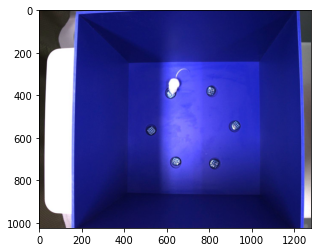

In [13]:
# select and display one random image from the training set
img_file = random.choice(glob.glob(f"{DATASET_DIR}/train/JPEGImages/*.*"))
im = cv2.imread(img_file)
if IN_COLAB:
    cv2_imshow(im)
else:
    plt.imshow(im)

Then, we create a Detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [14]:
cfg = get_cfg()

In [15]:
if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

In [16]:
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set threshold for this model
# Find a model from Detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [17]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 6, 74, 74, 65, 74, 68], device='cuda:0')
Boxes(tensor([[ 100.5904,   16.4716, 1262.0560,  977.0276],
        [ 504.0177,  541.5104,  551.6971,  589.2094],
        [ 898.6787,  518.7311,  947.8806,  568.1455],
        [  19.0260,  140.1515,  163.2243,  981.9127],
        [ 788.5672,  356.4314,  832.5961,  404.7740],
        [ 121.0352,    0.0000, 1254.3234,  988.9520]], device='cuda:0'))


In [18]:
outputs['instances'].pred_masks

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [

In [19]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='coco_2017_train',
          json_file='datasets/coco/annotations/instances_train2017.json',
          image_root='datasets/coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                   

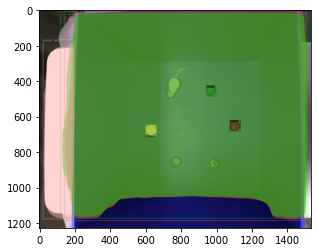

In [20]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
if IN_COLAB:
    cv2_imshow(out.get_image()[:, :, ::-1])
else:
    plt.imshow(out.get_image()[:, :, ::-1])

As we can see, the network doesn't detect what we want. That is expected as we have not fine-tuned the network with our custom dataset. We are going to do that in the next steps.